# Model Benchmarking


This notebook contains the code for the model benchmarking. We use the batched results from GPT, and a csv of results from Mistral models, to construct our analyses.

In [ ]:
import pandas as pd
import json
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
!pip install spacy
!pip install rapidfuzz
!pip install sentence_transformers
import pandas as pd
import numpy as np
import json
import spacy
from rapidfuzz import process, fuzz
import ast
nlp = spacy.load('en_core_web_sm')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from wordcloud import WordCloud
import string
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## pre processing batch outputs/tsvs

load the jsonls into dfs

In [ ]:
def load_jsonl(file):
    # Load the JSONL file
    results = []
    with open(file, 'r') as f:
        for line in f:
            results.append(json.loads(line))

    df = pd.DataFrame(results)

    # Define a function to safely extract and parse the model's response content
    def extract_model_response(response):
        try:
            # Extract the message content and parse it as JSON
            content = response['body']['choices'][0]['message']['content']
            parsed_content = json.loads(content)  # Convert content to dict from string
            return parsed_content
        except (KeyError, json.JSONDecodeError):
            # Return a default empty dict if parsing or extraction fails
            return {}

    # Apply the function to extract and parse the model responses
    df['model_response'] = df['response'].apply(extract_model_response)

    # Extract the 'class' and 'targets' safely
    df['pred_class'] = df['model_response'].apply(lambda x: 0 if x.get('class') == 'not_hate' else (1 if x.get('class') == 'hate' else None))
    df['pred_target'] = df['model_response'].apply(lambda x: x.get('targets', []))  # Default to an empty list if not found

    # Drop the intermediate 'model_response' column if no longer needed
    df = df.drop(columns=['id', 'custom_id', 'response', 'error', 'model_response'])

    return df

In [ ]:
gpt_results = load_jsonl('results_gpt.jsonl')
mini_results = load_jsonl('results_mini.jsonl')

In [ ]:
def load_csv(file):
    df = pd.read_csv(file)

    # Define a function to safely extract and parse the model's response content
    def extract_model_response(response):
        try:
            # Extract the message content and parse it as JSON
            parsed_content = json.loads(response)  # Convert content to dict from string
            return parsed_content
        except (KeyError, json.JSONDecodeError):
            # Return a default empty dict if parsing or extraction fails
            return {}

    # Apply the function to extract and parse the model responses
    df['model_response'] = df['output'].apply(extract_model_response)

    # Extract the 'class' and 'targets' safely
    df['pred_class'] = df['model_response'].apply(lambda x: 0 if x.get('class') == 'not_hate' else (1 if x.get('class') == 'hate' else None))
    df['pred_target'] = df['model_response'].apply(lambda x: x.get('targets', []))  # Default to an empty list if not found

    # Drop the intermediate 'model_response' column if no longer needed
    df = df.drop(columns=['output', 'model_response'])
    return df

In [ ]:
large_results = load_csv('results_large.csv')
small_results = load_csv('results_small.csv')

## concatenating dfs

In [ ]:
# Example base dataframe
base_df = pd.read_csv('processed_full_500.tsv', sep="\t")
base_df['binary_class'] = base_df['binary_class'].apply(lambda x: 0 if x == 'not_hate' else (1 if x == 'hate' else None))

# Example dictionary of dataframes
df_dict = {
    'gpt-4o': gpt_results,
    'gpt-4o-mini': mini_results,
    'mistral-large': large_results,
    'mistral-small': small_results
}

for key, df in df_dict.items():
    # Add prefix to the 'class' and 'target' columns from the current dataframe
    base_df[f'{key}_pred_class'] = df['pred_class']
    base_df[f'{key}_pred_target'] = df['pred_target']

# ensemble learning model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import pandas as pd
import joblib  # For saving and loading models

# Assuming 'base_df' is your original DataFrame
df = base_df.copy()

# Define the columns to process and the label column
columns_to_process = [
    'mistral-large_pred_class',
    'gpt-4o-mini_pred_class',
    'mistral-small_pred_class',
    'gpt-4o_pred_class'
]
label_column = 'binary_class'

# Define the parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],   # Regularization strength
    'penalty': ['l1', 'l2'],           # L1 and L2 regularization
    'solver': ['liblinear', 'saga']    # Solvers that support L1 (liblinear) and both (saga)
}

# Initialize a list to store results
results = []

# Initialize a dictionary to store models
models_dict = {}

# Generate all combinations of columns with size 2, 3, and 4
for r in range(2, len(columns_to_process) + 1):
    for combination in itertools.combinations(columns_to_process, r):
        print(f"Processing combination: {combination}")
        # Create a subset of the DataFrame with the selected columns and the label
        subset_columns = list(combination) + [label_column]
        df_subset = df[subset_columns].dropna()

        # Define feature matrix X and target vector y
        X = df_subset[list(combination)]
        y = df_subset[label_column]

        # Split data into training and test sets (80% train, 20% test)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Initialize Logistic Regression model
        lr_model = LogisticRegression(max_iter=1000)

        # Initialize GridSearchCV with Logistic Regression
        lr_grid_search = GridSearchCV(
            estimator=lr_model,
            param_grid=lr_param_grid,
            cv=5,
            scoring='f1',
            verbose=0,          # Set to 2 for detailed logs
            n_jobs=-1
        )

        # Fit the model
        try:
            lr_grid_search.fit(X_train, y_train)
        except Exception as e:
            print(f"Failed to fit model for combination {combination}: {e}")
            continue  # Skip this combination if there's an error

        # Get the best model from GridSearchCV
        lr_best_model = lr_grid_search.best_estimator_
        y_pred_lr = lr_best_model.predict(X_test)

        # Calculate evaluation metrics
        accuracy_lr = accuracy_score(y_test, y_pred_lr)
        precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
        recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)
        f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)

        # Store the results
        results.append({
            'Features': combination,
            'Best Parameters': lr_grid_search.best_params_,
            'Accuracy': accuracy_lr,
            'Precision': precision_lr,
            'Recall': recall_lr,
            'F1 Score': f1_lr
        })

        # Store the best model in the dictionary with combination as the key
        models_dict[combination] = lr_best_model

# Convert the results into a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Optionally, sort the results by F1 Score in descending order
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Display the top 5 results
print(results_df.head())

# Save the results to a CSV file (optional)
# results_df.to_csv('logistic_regression_feature_combinations_results.csv', index=False)

# Identify the best combination based on F1 Score
best_result = results_df.iloc[0]
best_features = best_result['Features']
best_params = best_result['Best Parameters']
best_f1 = best_result['F1 Score']

print("\nBest Model Details:")
print(f"Features: {best_features}")
print(f"Best Parameters: {best_params}")
print(f"F1 Score: {best_f1:.4f}")

# Retrieve the best model from the models_dict
best_model = models_dict[best_features]

Processing combination: ('mistral-large_pred_class', 'gpt-4o-mini_pred_class')
Processing combination: ('mistral-large_pred_class', 'mistral-small_pred_class')
Processing combination: ('mistral-large_pred_class', 'gpt-4o_pred_class')
Processing combination: ('gpt-4o-mini_pred_class', 'mistral-small_pred_class')
Processing combination: ('gpt-4o-mini_pred_class', 'gpt-4o_pred_class')
Processing combination: ('mistral-small_pred_class', 'gpt-4o_pred_class')
Processing combination: ('mistral-large_pred_class', 'gpt-4o-mini_pred_class', 'mistral-small_pred_class')
Processing combination: ('mistral-large_pred_class', 'gpt-4o-mini_pred_class', 'gpt-4o_pred_class')
Processing combination: ('mistral-large_pred_class', 'mistral-small_pred_class', 'gpt-4o_pred_class')
Processing combination: ('gpt-4o-mini_pred_class', 'mistral-small_pred_class', 'gpt-4o_pred_class')
Processing combination: ('mistral-large_pred_class', 'gpt-4o-mini_pred_class', 'mistral-small_pred_class', 'gpt-4o_pred_class')
    

In [ ]:
# Step 1: Identify the indices of the training data
train_indices = X_train.index

# Step 2: Filter the original DataFrame to get rows that were not used in training
# These will be the rows that do not have indices in `train_indices`
df_to_predict = base_df.loc[~base_df.index.isin(train_indices)]

# Step 3: Ensure you have the correct columns from the original dataframe to make predictions
# This is the same as the columns used for training
columns_to_process = ['mistral-small_pred_class', 'gpt-4o_pred_class']

# Step 4: Handle missing values by removing them from the rows where columns_to_process are NaN
df_to_predict_clean = df_to_predict[columns_to_process].dropna()

# Step 5: Use the trained model to make predictions on the data that was not used in training
predictions = best_model.predict(df_to_predict_clean)

# Step 6: Add the predictions as a new column in the `df_to_predict_clean` dataframe
df_to_predict_clean['ensemble_pred_class'] = predictions

# Step 7: Merge these predictions back to the original `base_df` by aligning on the index
# Only rows that were not in the training set will get the prediction
base_df = base_df.join(df_to_predict_clean['ensemble_pred_class'], how='left')

# Now `base_df_with_predictions` will have the predictions only for rows that were not in the training set


In [ ]:
base_df.head()

,Unnamed: 0,ID,class,post,implicit_class,target,target_new,binary_class,gpt-4o_pred_class,gpt-4o_pred_target,gpt-4o-mini_pred_class,gpt-4o-mini_pred_target,mistral-large_pred_class,mistral-large_pred_target,mistral-small_pred_class,mistral-small_pred_target,ensemble_pred_class
0,0,893818124356726784,not_hate,the new centry foundatin is a white supremacis...,NaN,NaN,[],0,1,[White supremacists],1,[white people],1,[non-white people],1.0,"[white supremacists, think tank]",NaN
1,1,810629155188539392,not_hate,i dont want to be controversial but im white 12,NaN,NaN,[],0,0,[],0,[],0,[],0.0,[],0.0
2,2,5393720593,not_hate,afire stands for americans for immigration ref...,NaN,NaN,[],0,0,[],0,[],0,[],0.0,[],NaN
3,3,915685988483108864,not_hate,its 75 white which is very high when the 22 po...,NaN,NaN,[],0,0,[],0,[],0,[],0.0,[],NaN
4,4,752622004885389312,not_hate,obama claims he doesnt know the motive of a se...,NaN,NaN,[],0,0,[],1,"[whites, white cops]",1,"[whites, white cops]",1.0,"[whites, white cops]",0.0


# results

## binary class

### text

In [ ]:
# Initialize a results dictionary to store metrics
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Confusion Matrix': []
}

# Iterate through each model's predictions
df_list = [
    'gpt-4o',
    'gpt-4o-mini',
    'mistral-large',
    'mistral-small',
    'ensemble'
]

for item in df_list:
    # Get predictions and true labels
    true_labels = base_df['binary_class']
    pred_labels = base_df[f'{item}_pred_class']  # Assuming each df in df_dict has a 'pred_class' column

    # Drop rows where either true labels or predicted labels are NaN
    valid_mask = true_labels.notna() & pred_labels.notna()
    true_labels_valid = true_labels[valid_mask]
    pred_labels_valid = pred_labels[valid_mask]

    # Check if there are any valid entries to calculate metrics
    if len(true_labels_valid) == 0 or len(pred_labels_valid) == 0:
        print(f"Warning: No valid entries for model {item}. Skipping...")
        continue

    # Calculate metrics
    accuracy = accuracy_score(true_labels_valid, pred_labels_valid)
    precision = precision_score(true_labels_valid, pred_labels_valid, average='binary')
    recall = recall_score(true_labels_valid, pred_labels_valid, average='binary')
    f1 = f1_score(true_labels_valid, pred_labels_valid, average='binary')
    cm = confusion_matrix(true_labels_valid, pred_labels_valid)

    # Append results
    results['Model'].append(item)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    results['Confusion Matrix'].append(cm)

# Create a DataFrame for results
results_df = pd.DataFrame(results)

# Iterate over the results DataFrame and print the metrics
for index, row in results_df.iterrows():
    print(f"Model: {row['Model']}")
    print(f"Accuracy: {row['Accuracy']:.4f}")
    print(f"Precision: {row['Precision']:.4f}")
    print(f"Recall: {row['Recall']:.4f}")
    print(f"F1 Score: {row['F1 Score']:.4f}")
    print(f"Confusion Matrix:\n{row['Confusion Matrix']}\n")

Model: gpt-4o
Accuracy: 0.7980
Precision: 0.8260
Recall: 0.7550
F1 Score: 0.7889
Confusion Matrix:
[[841 159]
 [245 755]]

Model: gpt-4o-mini
Accuracy: 0.7540
Precision: 0.6945
Recall: 0.9070
F1 Score: 0.7866
Confusion Matrix:
[[601 399]
 [ 93 907]]

Model: mistral-large
Accuracy: 0.6980
Precision: 0.6340
Recall: 0.9370
F1 Score: 0.7563
Confusion Matrix:
[[459 541]
 [ 63 937]]

Model: mistral-small
Accuracy: 0.7124
Precision: 0.6626
Recall: 0.8660
F1 Score: 0.7508
Confusion Matrix:
[[558 441]
 [134 866]]

Model: ensemble
Accuracy: 0.8200
Precision: 0.8333
Recall: 0.8000
F1 Score: 0.8163
Confusion Matrix:
[[168  32]
 [ 40 160]]



### plots

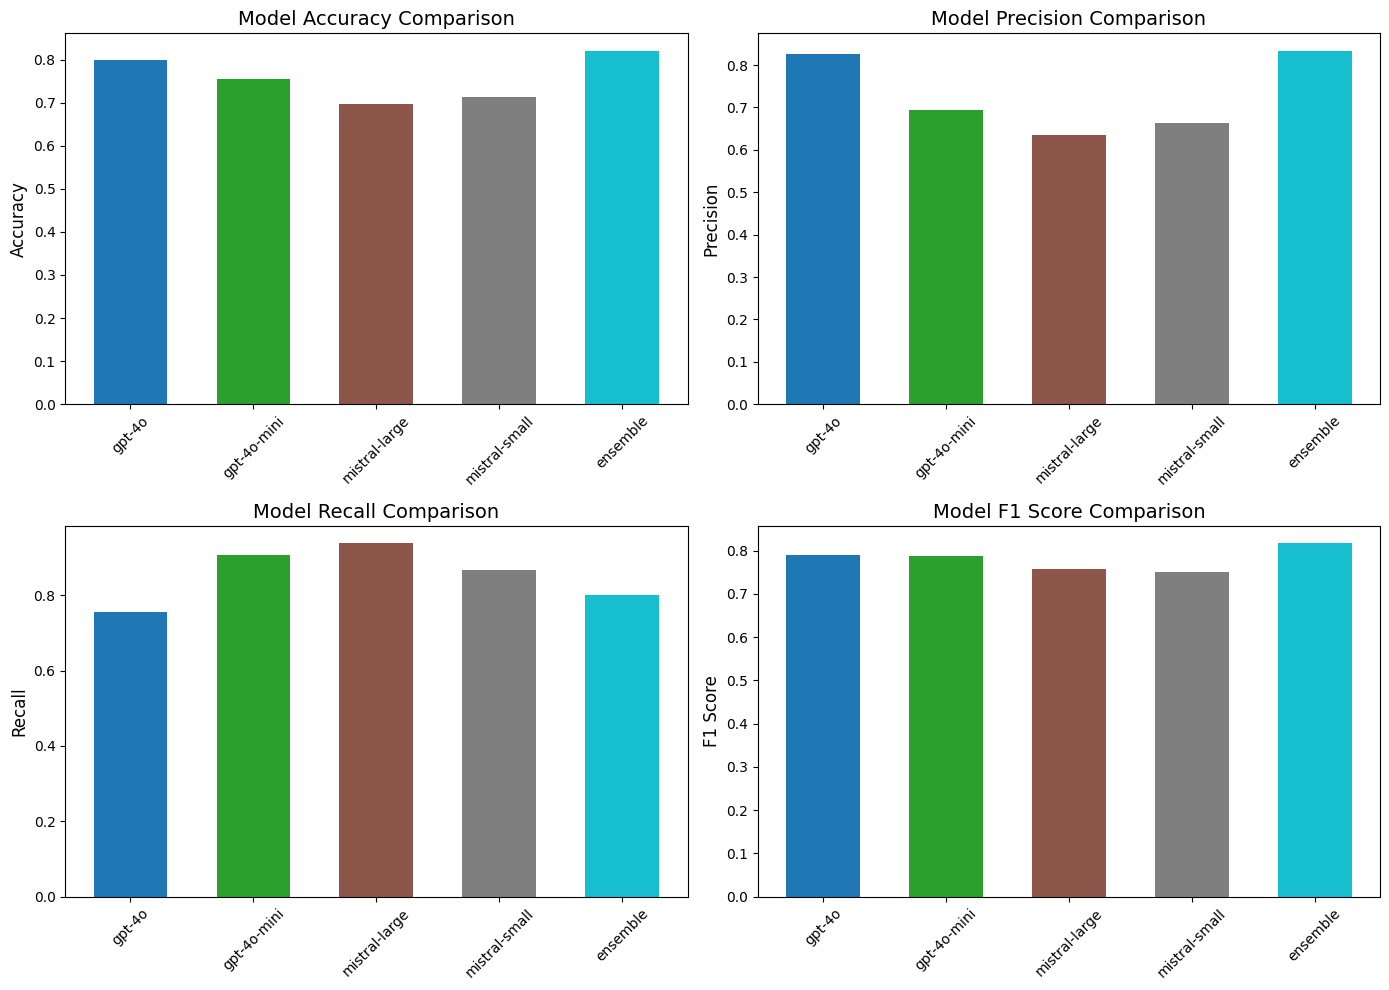

In [ ]:
# Define the models and their metrics
models = results_df['Model']
accuracy = results_df['Accuracy']
precision = results_df['Precision']
recall = results_df['Recall']
f1_score = results_df['F1 Score']

# Define a colormap for unique colors
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(models)))

# Set the width of the bars
bar_width = 0.6

# Create a 2x2 grid for the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Accuracy in the first subplot (top-left)
axes[0, 0].bar(models, accuracy, color=colors, width=bar_width)
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot Precision in the second subplot (top-right)
axes[0, 1].bar(models, precision, color=colors, width=bar_width)
axes[0, 1].set_title('Model Precision Comparison', fontsize=14)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot Recall in the third subplot (bottom-left)
axes[1, 0].bar(models, recall, color=colors, width=bar_width)
axes[1, 0].set_title('Model Recall Comparison', fontsize=14)
axes[1, 0].set_ylabel('Recall', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot F1 Score in the fourth subplot (bottom-right)
axes[1, 1].bar(models, f1_score, color=colors, width=bar_width)
axes[1, 1].set_title('Model F1 Score Comparison', fontsize=14)
axes[1, 1].set_ylabel('F1 Score', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust the layout to make sure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import jaccard_score

# Iterate through each model's predictions
df_list = [
    'gpt-4o',
    'gpt-4o-mini',
    'mistral-large',
    'mistral-small',
    'ensemble'
]

# Initialize an empty DataFrame to store the Jaccard similarity scores
jaccard_similarity_df = pd.DataFrame(index=df_list, columns=df_list)

# Loop through each model pair to calculate Jaccard similarity
for i, model_a in enumerate(df_list):
    for j, model_b in enumerate(df_list):
        if i <= j:  # No need to compute twice for symmetric values (i.e., A vs B and B vs A)
            # Get predictions for each model
            pred_labels_a = base_df[f'{model_a}_pred_class']
            pred_labels_b = base_df[f'{model_b}_pred_class']

            # Drop rows where either of the predictions is NaN
            valid_mask = pred_labels_a.notna() & pred_labels_b.notna()
            pred_labels_a_valid = pred_labels_a[valid_mask]
            pred_labels_b_valid = pred_labels_b[valid_mask]

            # Check if there are any valid entries to calculate metrics
            if len(pred_labels_a_valid) == 0 or len(pred_labels_b_valid) == 0:
                jaccard_similarity_df.loc[model_a, model_b] = None
                print(f"Warning: No valid entries for models {model_a} and {model_b}. Skipping...")
                continue

            # Calculate Jaccard similarity
            jaccard_sim = jaccard_score(pred_labels_a_valid, pred_labels_b_valid)

            # Store the Jaccard similarity in the DataFrame (both for [a, b] and [b, a] since it's symmetric)
            jaccard_similarity_df.loc[model_a, model_b] = jaccard_sim
            jaccard_similarity_df.loc[model_b, model_a] = jaccard_sim

# Print the Jaccard similarity matrix
print("Jaccard Similarity Matrix:")
print(jaccard_similarity_df)

Jaccard Similarity Matrix:
                 gpt-4o gpt-4o-mini mistral-large mistral-small  ensemble
gpt-4o              1.0    0.679274      0.610774       0.63429       1.0
gpt-4o-mini    0.679274         1.0      0.810143      0.804558  0.742188
mistral-large  0.610774    0.810143           1.0      0.809617  0.635452
mistral-small   0.63429    0.804558      0.809617           1.0  0.638298
ensemble            1.0    0.742188      0.635452      0.638298       1.0


## precision recall plots

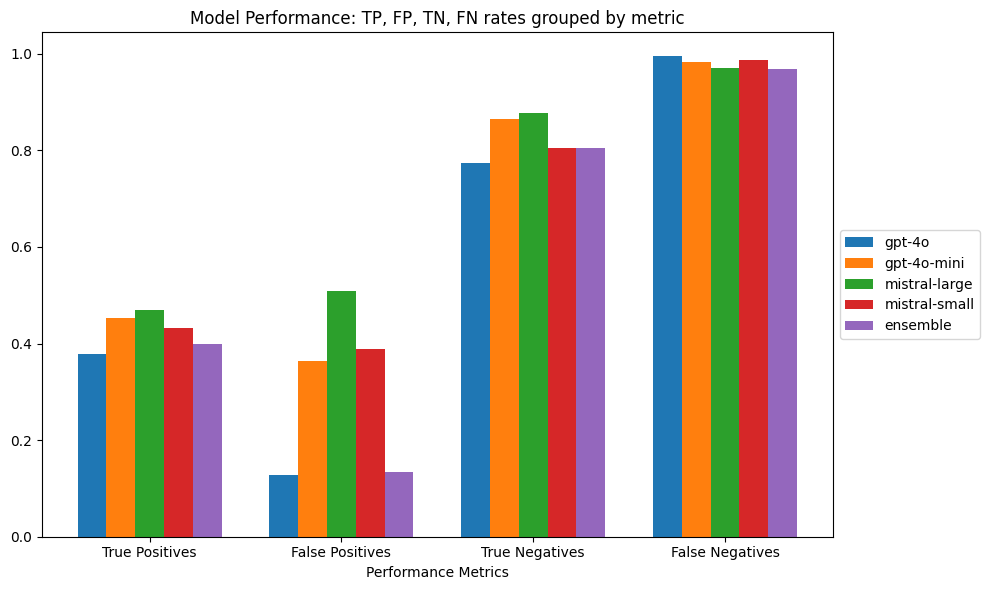

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# List of models
df_list = [
    'gpt-4o',
    'gpt-4o-mini',
    'mistral-large',
    'mistral-small',
    'ensemble'
]

# Initialize data storage for TP, FP, TN, FN rates
metrics = {'Model': [], 'TP': [], 'FP': [], 'TN': [], 'FN': []}

# Iterate through each model's predictions
for item in df_list:
    # Get predictions and true labels
    true_labels = base_df['binary_class']
    pred_labels = base_df[f'{item}_pred_class']  # Assuming each df in df_dict has a 'pred_class' column

    # Drop rows where either true labels or predicted labels are NaN
    valid_mask = true_labels.notna() & pred_labels.notna()
    true_labels_valid = true_labels[valid_mask]
    pred_labels_valid = pred_labels[valid_mask]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels_valid, pred_labels_valid)

    # Extract TP, FP, TN, FN from confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Store the metrics
    metrics['Model'].append(item)
    metrics['TP'].append(tp)
    metrics['FP'].append(fp)
    metrics['TN'].append(tn)
    metrics['FN'].append(fn)

# Convert metrics to percentages (optional, for better comparison)
for key in ['TP', 'FP', 'TN', 'FN']:
    metrics[key] = np.array(metrics[key]) / np.sum([metrics['TP'], metrics['FP'], metrics['TN'], metrics['FN']], axis=0)

# Transpose the metrics to group by metric
grouped_metrics = np.array([metrics['TP'], metrics['FP'], metrics['TN'], metrics['FN']])

# Bar plot grouped by metric
model_labels = df_list  # Model names for the labels
metric_labels = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
x = np.arange(len(metric_labels))  # label locations
width = 0.15  # width of bars

# Create subplots grouped by metric
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model, grouped by metric
for i, model in enumerate(model_labels):
    ax.bar(x + i * width - width*2, grouped_metrics[:, i], width, label=model)

# Add labels, title, and legend
ax.set_xlabel('Performance Metrics')
ax.set_title('Model Performance: TP, FP, TN, FN rates grouped by metric')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)

# Position legend on the middle right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to make room for the legend
plt.tight_layout()

# Save the plot as an image file
plt.savefig('model_performance_grouped_by_metric_final.png')

plt.show()

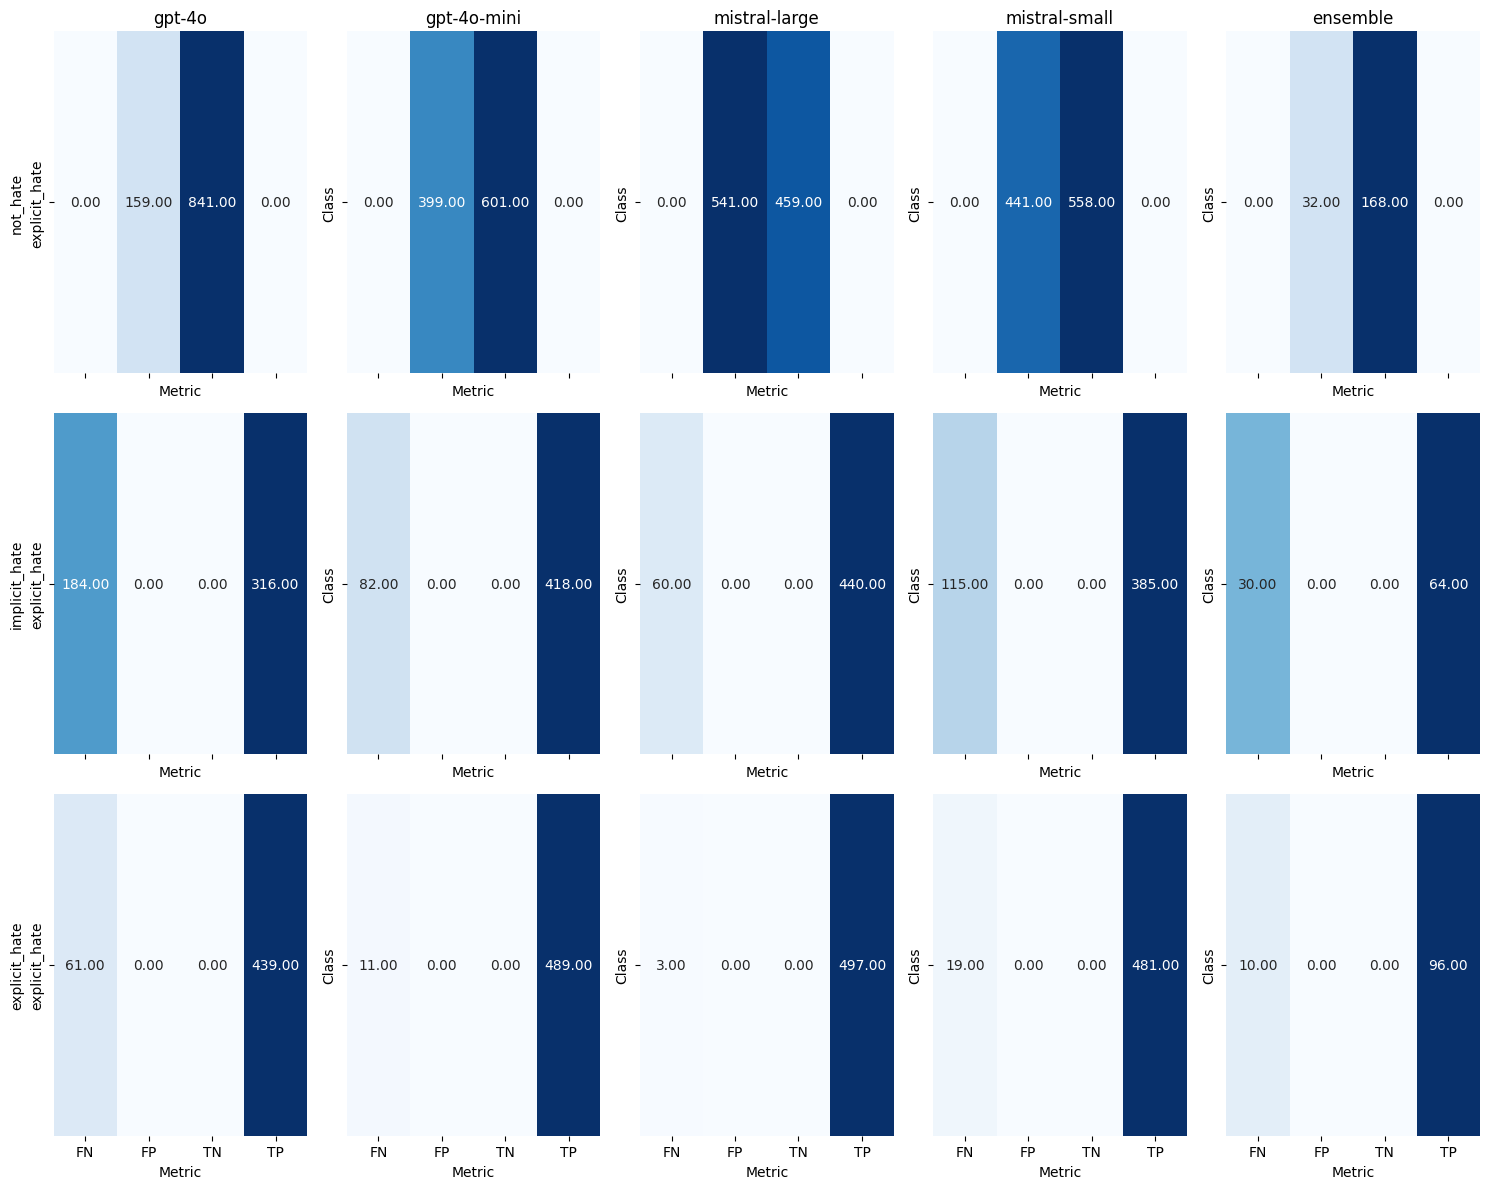

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

# List of models and predictions columns
models = [f'{item}_pred_class' for item in df_list]

# Initialize a dictionary to store analysis results
subclass_analysis = {'Model': [], 'Class': [], 'TP': [], 'FP': [], 'TN': [], 'FN': []}

# Perform analysis by subclass ('not_hate', 'explicit_hate', 'implicit_hate') for each model
for model in models:
    for subclass in base_df['class'].unique():
        # Filter the DataFrame for the current subclass
        subclass_df = base_df[base_df['class'] == subclass]

        # Get true labels and predicted labels for the current subclass and model
        true_labels = subclass_df['binary_class']
        pred_labels = subclass_df[model]

        # Drop rows where either true labels or predicted labels are NaN
        valid_mask = true_labels.notna() & pred_labels.notna()
        true_labels = true_labels[valid_mask]
        pred_labels = pred_labels[valid_mask]

        # Compute confusion matrix components
        tn = ((true_labels == 0) & (pred_labels == 0)).sum()
        tp = ((true_labels == 1) & (pred_labels == 1)).sum()
        fn = ((true_labels == 1) & (pred_labels == 0)).sum()
        fp = ((true_labels == 0) & (pred_labels == 1)).sum()

        # Store the results
        match = re.match(r'^(.*?)_pred_class$', model)
        item = match.group(1)

        subclass_analysis['Model'].append(item)
        subclass_analysis['Class'].append(subclass)
        subclass_analysis['TP'].append(tp)
        subclass_analysis['FP'].append(fp)
        subclass_analysis['TN'].append(tn)
        subclass_analysis['FN'].append(fn)

# Convert results to DataFrame for visualization
analysis_df = pd.DataFrame(subclass_analysis)

# Prepare the data for heatmaps by flattening the DataFrame
heatmap_data = analysis_df.melt(id_vars=['Model', 'Class'], var_name='Metric', value_name='Count')

# Create a grid of heatmaps, one for each model and subclass
fig, axes = plt.subplots(len(base_df['class'].unique()), len(models), figsize=(15, 12), sharex=True, sharey=True)

# Plot small heatmaps for each subclass and model
for i, subclass in enumerate(base_df['class'].unique()):
    for j, model in enumerate(models):
        # Filter the DataFrame for this specific model and subclass
        subset = heatmap_data[(heatmap_data['Model'] == model.replace('_pred_class', '')) & (heatmap_data['Class'] == subclass)]
        # Reshape data for heatmap plotting (TP, FP, TN, FN)
        metric_matrix = subset.pivot_table(index='Class', columns='Metric', values='Count')

        sns.heatmap(metric_matrix, annot=True, fmt=".2f", cmap='Blues', ax=axes[i, j], cbar=False)

        # Add titles and labels
        if i == 0:
            axes[i, j].set_title(model.replace('_pred_class', ''))
        if j == 0:
            axes[i, j].set_ylabel(subclass)

# Adjust layout and display
plt.tight_layout()
plt.show()

## multiclass class (implicit vs explicit)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# First, explicit hate
explicit_df = base_df.copy()
explicit_df = explicit_df[explicit_df['class'] == 'explicit_hate']

# First, implicit hate
implicit_df = base_df.copy()
implicit_df = implicit_df[implicit_df['class'] == 'implicit_hate']

# First, not hate
nothate_df = base_df.copy()
nothate_df = nothate_df[nothate_df['class'] == 'not_hate']

# Initialize a list to store the results for each model
model_metrics = []

# Iterate through each model's predictions
for item in df_list:
    # Initialize dictionaries to store cumulative results for averaging across all iterations
    metrics_explicit = {"precision": [], "recall": [], "f1": [], "accuracy": []}
    metrics_implicit = {"precision": [], "recall": [], "f1": [], "accuracy": []}

    for i in range(100):
        # Randomly sample the nohate_df so that it's the same size as the explicit_df
        nothate_sample = nothate_df.sample(n=len(explicit_df), random_state=i)

        # Concatenate this with explicit_df
        combined_df = pd.concat([explicit_df, nothate_sample])

        # Get true labels and predicted labels
        true_labels = combined_df['binary_class']
        pred_labels = combined_df[f'{item}_pred_class']

        # Remove NaN predictions
        valid_idx = ~pred_labels.isna()
        true_labels = true_labels[valid_idx]
        pred_labels = pred_labels[valid_idx]

        # Calculate precision, recall, f1, and accuracy if there are valid predictions
        if len(pred_labels) > 0:
            precision = precision_score(true_labels, pred_labels, pos_label=1)
            recall = recall_score(true_labels, pred_labels, pos_label=1)
            f1 = f1_score(true_labels, pred_labels, pos_label=1)
            accuracy = accuracy_score(true_labels, pred_labels)

            # Store the metrics
            metrics_explicit["precision"].append(precision)
            metrics_explicit["recall"].append(recall)
            metrics_explicit["f1"].append(f1)
            metrics_explicit["accuracy"].append(accuracy)

        # Now for implicit hate
        nothate_sample_implicit = nothate_df.sample(n=len(implicit_df), random_state=i)

        # Concatenate with implicit_df
        combined_df_implicit = pd.concat([implicit_df, nothate_sample_implicit])

        # Get true labels and predicted labels for the implicit sample
        true_labels_implicit = combined_df_implicit['binary_class']
        pred_labels_implicit = combined_df_implicit[f'{item}_pred_class']

        # Remove NaN predictions
        valid_idx_implicit = ~pred_labels_implicit.isna()
        true_labels_implicit = true_labels_implicit[valid_idx_implicit]
        pred_labels_implicit = pred_labels_implicit[valid_idx_implicit]

        # Calculate precision, recall, f1, and accuracy if there are valid predictions
        if len(pred_labels_implicit) > 0:
            precision_implicit = precision_score(true_labels_implicit, pred_labels_implicit, pos_label=1)
            recall_implicit = recall_score(true_labels_implicit, pred_labels_implicit, pos_label=1)
            f1_implicit = f1_score(true_labels_implicit, pred_labels_implicit, pos_label=1)
            accuracy_implicit = accuracy_score(true_labels_implicit, pred_labels_implicit)

            # Store the metrics
            metrics_implicit["precision"].append(precision_implicit)
            metrics_implicit["recall"].append(recall_implicit)
            metrics_implicit["f1"].append(f1_implicit)
            metrics_implicit["accuracy"].append(accuracy_implicit)

    # Calculate average metrics after all iterations
    avg_explicit_precision = np.mean(metrics_explicit['precision'])
    avg_explicit_recall = np.mean(metrics_explicit['recall'])
    avg_explicit_f1 = np.mean(metrics_explicit['f1'])
    avg_explicit_accuracy = np.mean(metrics_explicit['accuracy'])

    avg_implicit_precision = np.mean(metrics_implicit['precision'])
    avg_implicit_recall = np.mean(metrics_implicit['recall'])
    avg_implicit_f1 = np.mean(metrics_implicit['f1'])
    avg_implicit_accuracy = np.mean(metrics_implicit['accuracy'])

    # Save the averaged metrics for this model
    model_metrics.append({
        'model': item,
        'explicit_precision': avg_explicit_precision,
        'explicit_recall': avg_explicit_recall,
        'explicit_f1': avg_explicit_f1,
        'explicit_accuracy': avg_explicit_accuracy,
        'implicit_precision': avg_implicit_precision,
        'implicit_recall': avg_implicit_recall,
        'implicit_f1': avg_implicit_f1,
        'implicit_accuracy': avg_implicit_accuracy
    })

# Convert the results into a DataFrame for comparison
metrics_df = pd.DataFrame(model_metrics)

In [ ]:
for index, row in metrics_df.iterrows():
    print(f"Model: {row['model']}")
    print(f"Explicit Hate Metrics:")
    print(f"  Precision: {row['explicit_precision']:.4f}")
    print(f"  Recall: {row['explicit_recall']:.4f}")
    print(f"  F1 Score: {row['explicit_f1']:.4f}")
    print(f"  Accuracy: {row['explicit_accuracy']:.4f}")
    print("\nImplicit Hate Metrics:")
    print(f"  Precision: {row['implicit_precision']:.4f}")
    print(f"  Recall: {row['implicit_recall']:.4f}")
    print(f"  F1 Score: {row['implicit_f1']:.4f}")
    print(f"  Accuracy: {row['implicit_accuracy']:.4f}")
    print("-" * 50)  # Separator between models

Model: gpt-4o
Explicit Hate Metrics:
  Precision: 0.8474
  Recall: 0.8780
  F1 Score: 0.8624
  Accuracy: 0.8599

Implicit Hate Metrics:
  Precision: 0.7999
  Recall: 0.6320
  F1 Score: 0.7061
  Accuracy: 0.7369
--------------------------------------------------
Model: gpt-4o-mini
Explicit Hate Metrics:
  Precision: 0.7091
  Recall: 0.9780
  F1 Score: 0.8221
  Accuracy: 0.7883

Implicit Hate Metrics:
  Precision: 0.6757
  Recall: 0.8360
  F1 Score: 0.7473
  Accuracy: 0.7173
--------------------------------------------------
Model: mistral-large
Explicit Hate Metrics:
  Precision: 0.6472
  Recall: 0.9940
  F1 Score: 0.7839
  Accuracy: 0.7260

Implicit Hate Metrics:
  Precision: 0.6189
  Recall: 0.8800
  F1 Score: 0.7267
  Accuracy: 0.6690
--------------------------------------------------
Model: mistral-small
Explicit Hate Metrics:
  Precision: 0.6847
  Recall: 0.9620
  F1 Score: 0.8000
  Accuracy: 0.7593

Implicit Hate Metrics:
  Precision: 0.6349
  Recall: 0.7700
  F1 Score: 0.6959
  A

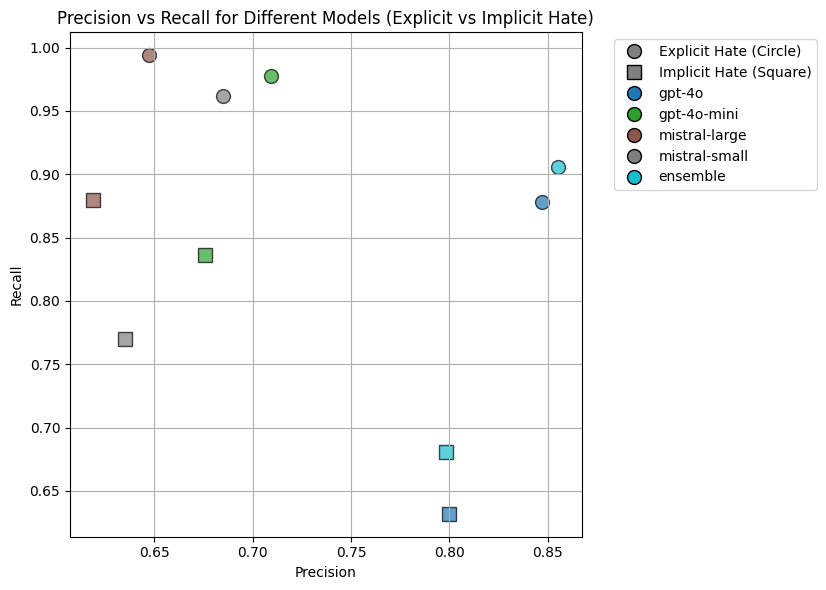

In [ ]:
from matplotlib.lines import Line2D

# Define a color map for models
color_map = plt.cm.get_cmap('tab10', len(metrics_df['model']))

# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Iterate through the models and plot both explicit and implicit metrics
for i, row in metrics_df.iterrows():
    model_name = row['model']

    # Get precision and recall for explicit and implicit hate
    explicit_precision = row['explicit_precision']
    explicit_recall = row['explicit_recall']
    implicit_precision = row['implicit_precision']
    implicit_recall = row['implicit_recall']

    # Plot explicit hate (circles) - different color per model
    plt.scatter(explicit_precision, explicit_recall,
                color=color_map(i), marker='o', s=100, edgecolor='black', alpha=0.7)

    # Plot implicit hate (squares) - different color per model
    plt.scatter(implicit_precision, implicit_recall,
                color=color_map(i), marker='s', s=100, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs Recall for Different Models (Explicit vs Implicit Hate)')
plt.grid(True)

# Create custom legend elements for explicit and implicit markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10,
           label='Explicit Hate (Circle)', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=10,
           label='Implicit Hate (Square)', markeredgecolor='black')
]

# Add model color markers to the legend
model_colors = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i),
                       markersize=10, label=model_name, markeredgecolor='black')
                for i, model_name in enumerate(metrics_df['model'])]

# Combine the two types of legends: markers for hate type and colors for models
plt.legend(handles=legend_elements + model_colors, loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout to fit the legend and plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for the legend
plt.show()


In [ ]:
import pandas as pd

# Assuming base_df is your DataFrame and is already defined
# base_df should contain 'binary_class', 'post', and '{model}_pred_class' columns

# List of models
df_list = [
    'gpt-4o',
    'gpt-4o-mini',
    'mistral-large',
    'mistral-small',
    'ensemble'
]

# Step 1: Collect all predictions into a new DataFrame
predictions = pd.DataFrame()
for model in df_list:
    pred_col = f'{model}_pred_class'
    if pred_col in base_df.columns:
        predictions[model] = base_df[pred_col]
    else:
        raise ValueError(f"Column '{pred_col}' not found in base_df.")

# Step 2: Filter out rows with any NaN in true labels or predictions
valid_mask = base_df['binary_class'].notna() & predictions.notna().all(axis=1)
true_labels_valid = base_df.loc[valid_mask, 'binary_class']
predictions_valid = predictions.loc[valid_mask]

# Step 3: Identify misclassifications for each model
misclassifications = predictions_valid.ne(true_labels_valid, axis=0)

# Step 4: Find rows where all models misclassified
all_misclassified_mask = misclassifications.all(axis=1)

# Extract the filtered DataFrame, including the 'post' column
misclassified_df = base_df.loc[valid_mask & all_misclassified_mask, ['binary_class', 'post'] + [f'{model}_pred_class' for model in df_list]]

# Step 5: Find the first positive misclassified instance
first_positive = misclassified_df[misclassified_df['binary_class'] == 1].head(5)

# Find the first negative misclassified instance
first_negative = misclassified_df[misclassified_df['binary_class'] == 0].head(5)

# Step 6: Configure pandas to display the 'post' column in full
# Store current display options
current_max_colwidth = pd.get_option('display.max_colwidth')
current_display_width = pd.get_option('display.width')

# Set display options to show full content of 'post' and wider display
pd.set_option('display.max_colwidth', None)  # or use a large number like 1000
pd.set_option('display.width', 1000)

# Step 7: Print the results
if not first_positive.empty:
    print("First positive instance where all models misclassified:")
    print(first_positive.to_string(index=False))
else:
    print("No positive instances were misclassified by all models.")

if not first_negative.empty:
    print("\nFirst negative instance where all models misclassified:")
    print(first_negative.to_string(index=False))
else:
    print("\nNo negative instances were misclassified by all models.")

# Restore original pandas display options
pd.set_option('display.max_colwidth', current_max_colwidth)
pd.set_option('display.width', current_display_width)


First positive instance where all models misclassified:
 binary_class                                                                                                                        post  gpt-4o_pred_class  gpt-4o-mini_pred_class  mistral-large_pred_class  mistral-small_pred_class  ensemble_pred_class
            1                                                         even if i tell him he wont listen because hes quite bright actually                  0                       0                         0                       0.0                  0.0
            1 im actually saving for a set of bagpipes what better way to honor your heritage than learning their traditional instruments                  0                       0                         0                       0.0                  0.0
            1   your mom is brazilian isnt she maybe she could come to the school sometime for gym and teach the class how to dance samba                  0                       0  

In [ ]:
import pandas as pd

# Assuming base_df is your DataFrame and is already defined
# base_df should contain:
# - 'binary_class' column (with values 0 or 1)
# - 'post' column (containing the content)
# - '{model}_pred_class' columns for each model in df_list

# List of models
df_list = [
    'gpt-4o',
    'gpt-4o-mini',
    'mistral-large',
    'mistral-small',
    'ensemble'
]

# Step 1: Collect all predictions into a new DataFrame
predictions = pd.DataFrame()
for model in df_list:
    pred_col = f'{model}_pred_class'
    if pred_col in base_df.columns:
        predictions[model] = base_df[pred_col]
    else:
        raise ValueError(f"Column '{pred_col}' not found in base_df.")

# Step 2: Filter out rows with any NaN in true labels or predictions
valid_mask = base_df['binary_class'].notna() & predictions.notna().all(axis=1)
base_df_valid = base_df.loc[valid_mask].reset_index(drop=True)
predictions_valid = predictions.loc[valid_mask].reset_index(drop=True)

# Step 3: Define the filtering criteria

# True label is positive
positive_mask = base_df_valid['binary_class'] == 1

# Mistral models and ensemble correctly classified
mistral_and_ensemble_correct = (
    (predictions_valid['mistral-large'] == base_df_valid['binary_class']) &
    (predictions_valid['mistral-small'] == base_df_valid['binary_class'])
)

# GPT models did NOT correctly classify
gpt_models_incorrect = (
    (predictions_valid['gpt-4o'] != base_df_valid['binary_class']) &
    (predictions_valid['gpt-4o-mini'] != base_df_valid['binary_class'])
)

# Combined mask
final_mask = positive_mask & mistral_and_ensemble_correct & gpt_models_incorrect

# Step 4: Extract the desired instances
desired_instances = base_df_valid.loc[final_mask, ['post']]

# Step 5: Select the first 5 instances
first_five_posts = desired_instances.head(5)

# Step 6: Configure pandas to display the 'post' column in full
# Store current display options
current_max_colwidth = pd.get_option('display.max_colwidth')
current_display_width = pd.get_option('display.width')

# Set display options to show full content of 'post' and wider display
pd.set_option('display.max_colwidth', None)  # Remove limit on column width
pd.set_option('display.width', 1000)        # Increase display width if necessary

# Step 7: Print the results
num_posts = first_five_posts.shape[0]
if num_posts > 0:
    print(f"First {num_posts} positive instances where both Mistral models and Ensemble correctly classified, but GPT models did not:\n")
    for idx, row in first_five_posts.iterrows():
        print(f"Instance {idx + 1}:")
        print(row['post'])
        print("-" * 80)
else:
    print("No positive instances found that meet the specified criteria.")

# Step 8: Restore original pandas display options
pd.set_option('display.max_colwidth', current_max_colwidth)
pd.set_option('display.width', current_display_width)


First 5 positive instances where both Mistral models and Ensemble correctly classified, but GPT models did not:

Instance 245:
refugees can go right to social security and all other social benefits day one
--------------------------------------------------------------------------------
Instance 249:
sounds like some sort of skinhead thing which is the complete opposite of identity evropas aesthetic
--------------------------------------------------------------------------------
Instance 269:
this is the sort of selfdetermination we and the broader altright supportwould you like to discuss this in a public forum
--------------------------------------------------------------------------------
Instance 286:
along with illinois new york massachusetts new jersey washington oregon and more coming however they better not pollute the red states they moved to cuz there will b e hell to pay
--------------------------------------------------------------------------------
Instance 297:
trump is th

## statistical significance

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

columns_to_process = [
    'mistral-large_pred_class',
    'gpt-4o-mini_pred_class',
    'mistral-small_pred_class',
    'gpt-4o_pred_class'
]
label_column = 'binary_class'

# Now perform McNemar test between models to check statistical significance
results = {}
for i, model_1 in enumerate(columns_to_process):
    for j, model_2 in enumerate(columns_to_process):
        if i < j:  # Avoid redundant comparisons and self-comparison
            # Create contingency table
            contingency_table = pd.crosstab(df[model_1] == df[label_column],
                                            df[model_2] == df[label_column])

            # Perform McNemar test
            result = mcnemar(contingency_table, exact=True)
            p_value = result.pvalue
            results[(model_1, model_2)] = p_value

# Display McNemar test results
print("\nMcNemar Test Results (p-values):")
for models, p_value in results.items():
    print(f"Comparison between {models[0]} and {models[1]}: p-value = {p_value:.4f}")


McNemar Test Results (p-values):
Comparison between mistral-large_pred_class and gpt-4o-mini_pred_class: p-value = 0.0000
Comparison between mistral-large_pred_class and mistral-small_pred_class: p-value = 0.1152
Comparison between mistral-large_pred_class and gpt-4o_pred_class: p-value = 0.0000
Comparison between gpt-4o-mini_pred_class and mistral-small_pred_class: p-value = 0.0000
Comparison between gpt-4o-mini_pred_class and gpt-4o_pred_class: p-value = 0.0000
Comparison between mistral-small_pred_class and gpt-4o_pred_class: p-value = 0.0000


In [ ]:
import pandas as pd
from scipy.stats import binomtest
import statsmodels.stats.multitest as multitest

# Sample DataFrame setup (Replace this with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Define the columns
columns_to_process = [
    'mistral-large_pred_class',
    'gpt-4o-mini_pred_class',
    'mistral-small_pred_class',
    'gpt-4o_pred_class'
]
label_column = 'binary_class'

# Calculate the majority class proportion
majority_class_count = df[label_column].value_counts().max()
total = len(df)
p0 = majority_class_count / total

print(f"Baseline accuracy (p0) based on majority class: {p0:.4f}")

# Initialize lists to store results
results = []

for col in columns_to_process:
    # Calculate the number of correct predictions
    correct_predictions = (df[col] == df[label_column]).sum()
    n = len(df)
    observed_accuracy = correct_predictions / n

    # Perform the binomial test using binomtest
    test_result = binomtest(k=correct_predictions, n=n, p=p0, alternative='greater')
    p_value = test_result.pvalue

    results.append({
        'Model': col,
        'Correct Predictions': correct_predictions,
        'Total Predictions': n,
        'Observed Accuracy': observed_accuracy,
        'Baseline Accuracy (p0)': p0,
        'p-value': p_value
    })

# Create a DataFrame of results
results_df = pd.DataFrame(results)

# Adjust p-values for multiple comparisons (optional)
# Here, using the Bonferroni correction
reject, pvals_corrected, _, _ = multitest.multipletests(results_df['p-value'], method='bonferroni')
results_df['p-value_corrected'] = pvals_corrected
results_df['Significant'] = reject

# Display the results
print(results_df)

Baseline accuracy (p0) based on majority class: 0.5000
                      Model  Correct Predictions  Total Predictions  \
0  mistral-large_pred_class                 1396               2000   
1    gpt-4o-mini_pred_class                 1508               2000   
2  mistral-small_pred_class                 1424               2000   
3         gpt-4o_pred_class                 1596               2000   

   Observed Accuracy  Baseline Accuracy (p0)        p-value  \
0              0.698                     0.5   3.368001e-72   
1              0.754                     0.5  1.026135e-119   
2              0.712                     0.5   8.264889e-83   
3              0.798                     0.5  2.848231e-167   

   p-value_corrected  Significant  
0       1.347200e-71         True  
1      4.104541e-119         True  
2       3.305956e-82         True  
3      1.139292e-166         True  


## jaccard

Jaccard Similarity with True Labels:
                      Model  Jaccard_Similarity
0  mistral-large_pred_class            0.608047
1    gpt-4o-mini_pred_class            0.648320
2  mistral-small_pred_class            0.600972
3         gpt-4o_pred_class            0.651424

Pairwise Jaccard Similarity Between Models:
                                          Model_Pair  Jaccard_Similarity
0  mistral-large_pred_class vs gpt-4o-mini_pred_c...            0.810143
1  mistral-large_pred_class vs mistral-small_pred...            0.809617
2      mistral-large_pred_class vs gpt-4o_pred_class            0.610774
3  gpt-4o-mini_pred_class vs mistral-small_pred_c...            0.804558
4        gpt-4o-mini_pred_class vs gpt-4o_pred_class            0.679274
5      mistral-small_pred_class vs gpt-4o_pred_class            0.634290


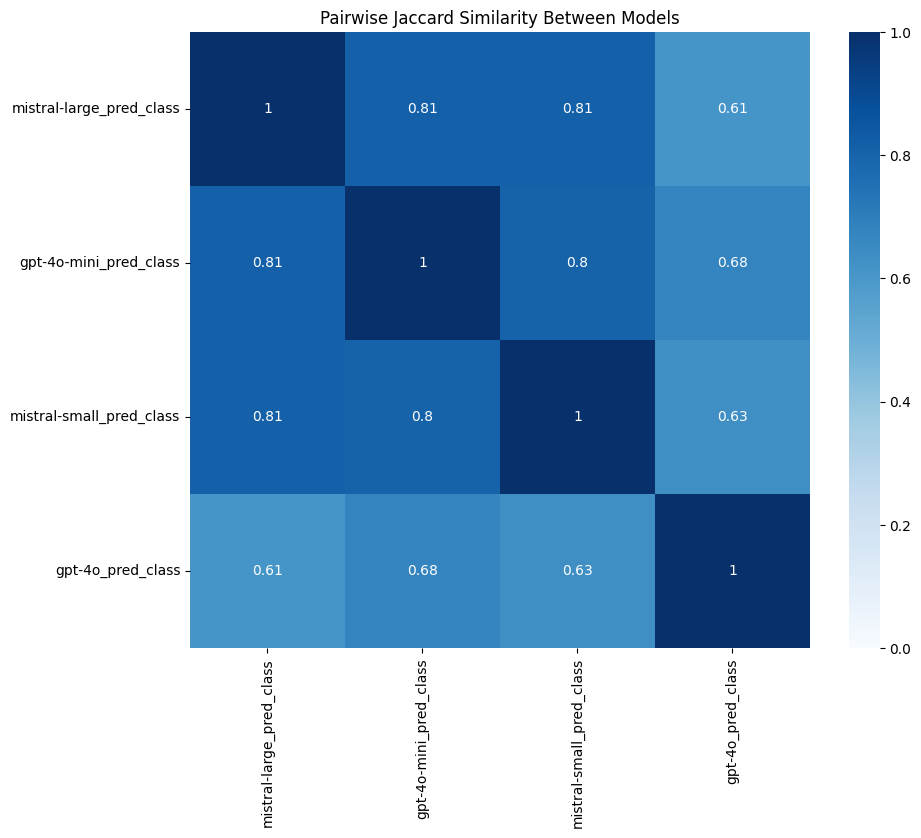

In [ ]:
from sklearn.metrics import jaccard_score
from itertools import combinations
import seaborn as sns

def compute_jaccard_with_labels(df, prediction_columns, label_column):
    jaccard_results = {}
    for col in prediction_columns:
        # Select rows where neither the label nor the prediction is NaN
        valid_rows = df[[label_column, col]].dropna()

        # Ensure binary format (0 and 1)
        y_true = valid_rows[label_column]
        y_pred = valid_rows[col]

        # Check if y_true and y_pred contain only binary values
        if set(y_true.unique()).issubset({0, 1}) and set(y_pred.unique()).issubset({0, 1}):
            jaccard = jaccard_score(y_true, y_pred)
            jaccard_results[col] = jaccard
        else:
            print(f"Warning: Non-binary values found in column '{col}' or '{label_column}'. Skipping Jaccard computation for this column.")
            jaccard_results[col] = None
    return pd.DataFrame(list(jaccard_results.items()), columns=['Model', 'Jaccard_Similarity'])

def compute_pairwise_jaccard(df, prediction_columns):
    pairwise_results = {}
    for col1, col2 in combinations(prediction_columns, 2):
        # Select rows where neither of the predictions is NaN
        valid_rows = df[[col1, col2]].dropna()

        y_pred1 = valid_rows[col1]
        y_pred2 = valid_rows[col2]

        # Check if y_pred1 and y_pred2 contain only binary values
        if set(y_pred1.unique()).issubset({0, 1}) and set(y_pred2.unique()).issubset({0, 1}):
            jaccard = jaccard_score(y_pred1, y_pred2)
            pairwise_results[f"{col1} vs {col2}"] = jaccard
        else:
            print(f"Warning: Non-binary values found in columns '{col1}' or '{col2}'. Skipping Jaccard computation for this pair.")
            pairwise_results[f"{col1} vs {col2}"] = None
    return pd.DataFrame(list(pairwise_results.items()), columns=['Model_Pair', 'Jaccard_Similarity'])

def plot_pairwise_jaccard_heatmap(df, prediction_columns):
    similarity_matrix = pd.DataFrame(index=prediction_columns, columns=prediction_columns, dtype=float)
    for col1 in prediction_columns:
        for col2 in prediction_columns:
            if col1 == col2:
                similarity_matrix.loc[col1, col2] = 1.0
            elif pd.isna(similarity_matrix.loc[col1, col2]):
                # Select rows where neither of the predictions is NaN
                valid_rows = df[[col1, col2]].dropna()
                y_pred1 = valid_rows[col1]
                y_pred2 = valid_rows[col2]

                # Check if y_pred1 and y_pred2 contain only binary values
                if set(y_pred1.unique()).issubset({0, 1}) and set(y_pred2.unique()).issubset({0, 1}):
                    jaccard = jaccard_score(y_pred1, y_pred2)
                    similarity_matrix.loc[col1, col2] = jaccard
                    similarity_matrix.loc[col2, col1] = jaccard
                else:
                    print(f"Warning: Non-binary values found in columns '{col1}' or '{col2}'. Setting similarity to NaN.")
                    similarity_matrix.loc[col1, col2] = None
                    similarity_matrix.loc[col2, col1] = None
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix.astype(float), annot=True, cmap='Blues', vmin=0, vmax=1)
    plt.title('Pairwise Jaccard Similarity Between Models')
    plt.show()

# Compute Jaccard similarity with labels
jaccard_with_labels = compute_jaccard_with_labels(base_df, columns_to_process, label_column)
print("Jaccard Similarity with True Labels:")
print(jaccard_with_labels)

# Compute pairwise Jaccard similarity between models
pairwise_jaccard = compute_pairwise_jaccard(base_df, columns_to_process)
print("\nPairwise Jaccard Similarity Between Models:")
print(pairwise_jaccard)

# Plot pairwise Jaccard similarity heatmap
plot_pairwise_jaccard_heatmap(base_df, columns_to_process)